# Import Packages

In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import utils
import pandas as pd
import numpy as np
import math
import random
from isoweek import Week
import lightgbm as lgb
import pickle
from sklearn.metrics import mean_squared_error

# Settings

In [2]:
forecast_horizon = 1
path_models = utils.get_project_root() + '/03_Forecasting_LightGBM/models/'
target_variable = 'Turnover' # Either 'Turnover' or 'Sales_QTY'

# Import Data

In [3]:
query = 'SELECT * FROM `globus-datahub-dev.Verteiler_PoC.timeseries_sales_weekly` where Year >= 2015 and (Year <= 2019 OR (Year = 2020 AND Week <= 47))  order by sku, site_id, year, week'
df_raw = utils.bq_to_dataframe(
    query, verbose=True).pipe(utils.reduce_memory_usage)

********************
Query Duration:  0:13:50.953166
Mem. usage decreased to 1469.44 Mb (15.1% reduction)


In [4]:
df = df_raw.copy()
df

,Week,Year,Date,Site_ID,SKU,Sales_QTY,Turnover,Price,Season_Year,Vendor_ID,...,Warengruppe_ID,Warengruppe_Desc,Subclass_Desc,Class_Desc,Web_Article,Web_Article_From,Web_Article_To,CENSHARE_CAT_1,CENSHARE_CAT_2,CENSHARE_CAT_3
0,1,2015,2015W1,101,1014557,5.0,129.500000,25.90,9999,0000126656,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
1,2,2015,2015W2,101,1014557,2.0,51.799999,25.90,9999,0000126656,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
2,3,2015,2015W3,101,1014557,0.0,0.000000,25.90,9999,0000126656,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
3,4,2015,2015W4,101,1014557,1.0,25.900000,25.90,9999,0000126656,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
4,5,2015,2015W5,101,1014557,0.0,0.000000,25.90,9999,0000126656,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7821434,47,2020,2020W47,101,1289328500,4.0,56.090000,14.90,9999,0000948934,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
7821435,47,2020,2020W47,101,1289328600,2.0,29.799999,14.90,9999,0000948934,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
7821436,47,2020,2020W47,101,1289328700,5.0,32.869999,6.57,9999,0000948934,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
7821437,47,2020,2020W47,101,1289328800,4.0,27.600000,6.90,9999,0000948934,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe


# Preprocess Data

In [5]:
# Get rid of negative Sales / Turnover
df.loc[:, 'Sales_QTY'] = df.Sales_QTY.clip(lower=0)
df.loc[:, 'Turnover'] = df.Turnover.clip(lower=0)

# Replace Censhare Cat if not applicable
df.loc[df.CENSHARE_CAT_1.isna(), 'CENSHARE_CAT_1'] = 'NA'

# Aggregated Data

## Aggregation

In [6]:
df_aggregated = pd.pivot_table(df, values=target_variable, index=['Year','Week','Date','CENSHARE_CAT_1'], aggfunc=np.sum)
df_aggregated.reset_index(level=df_aggregated.index.names, inplace=True)

In [7]:
df_aggregated

,Year,Week,Date,CENSHARE_CAT_1,Turnover
0,2015,1,2015W1,Bad,11483.400391
1,2015,1,2015W1,Bett,35661.351562
2,2015,1,2015W1,Elektronik Gadget,636.500000
3,2015,1,2015W1,Heim & Haushalt,1992.900024
4,2015,1,2015W1,Kinder,124.700005
...,...,...,...,...,...
5006,2020,47,2020W47,Outdoor,3029.050049
5007,2020,47,2020W47,Papeterie,52301.050781
5008,2020,47,2020W47,Reisegepack,39834.179688
5009,2020,47,2020W47,Tisch,177187.046875


## Visualize Timeseries

In [8]:
def plot_timeseries(samples: int, sales: pd.core.frame.DataFrame) -> None:
    """
    Vizualize certain timeseries.
    :param: samples: list of Censhare 1 Categories - category to be vizualized.
            Example: ['Reisegepack', 'Papeterie','Kinder']
    :param: sales: DataFrame containing the sales data (columns SKU, Site_ID & Year_Week required)
    :return None
    """
    fig, axs = plt.subplots(math.ceil(n_series / 2), 2, figsize=(15, n_series * 1.5))
    axs = axs.flatten()
    ax_idx = 0

    for category in samples:
        df_article = sales.loc[sales.CENSHARE_CAT_1 == category].sort_values(by=['Year', 'Week']).reset_index()

        df_article.plot(x='Date',
                     y=target_variable,
                     title= f'CENSHARE_CAT_1: {category}',
                     ax=axs[ax_idx])
        ax_idx += 1

    plt.tight_layout()
    plt.show()

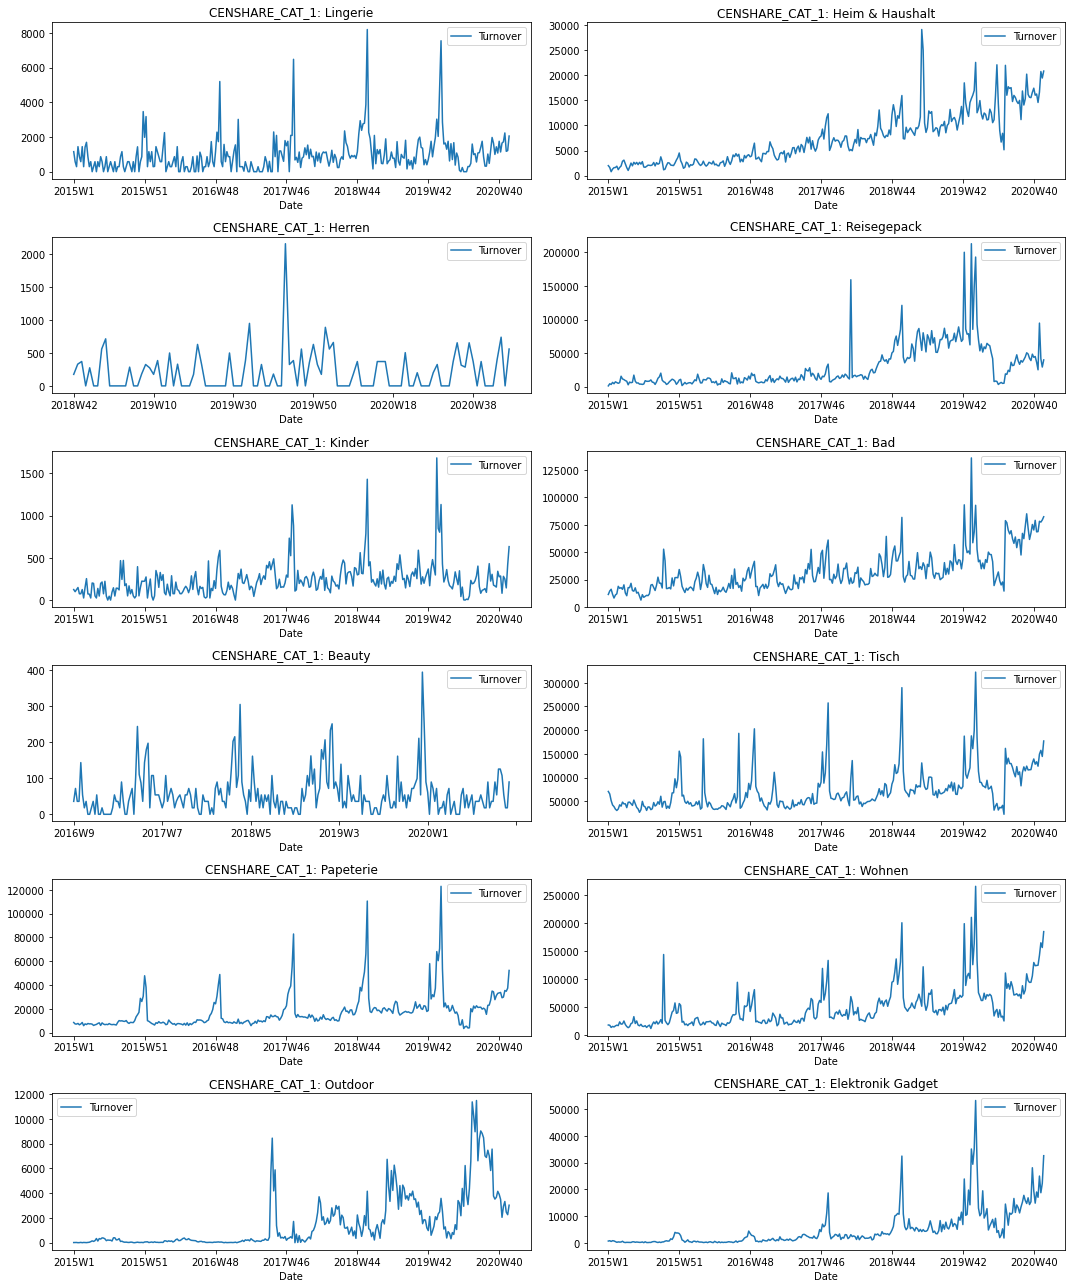

In [9]:
n_series = 12

samples = df_aggregated['CENSHARE_CAT_1'].drop_duplicates().sample(n=n_series, random_state=4).values.tolist()

plot_timeseries(samples, df_aggregated)

## Feature Engineering

In [10]:
df_aggregated['rolling_mean_w4'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(1).rolling(window=4,min_periods=0).mean()).fillna(0)

df_aggregated['rolling_mean_w8'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(1).rolling(window=8,min_periods=0).mean()).fillna(0)

df_aggregated['lag_w1'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(1))

df_aggregated['lag_w2'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(2))

df_aggregated['lag_w3'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(3))

df_aggregated['lag_w4'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(4))

df_aggregated['lag_y1'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(52))

df_aggregated['lag_y2'] = df_aggregated.sort_values(by=['Year', 'Week']).groupby(
    'CENSHARE_CAT_1')[target_variable].transform(lambda x: x.shift(104))

In [11]:
df_aggregated

,Year,Week,Date,CENSHARE_CAT_1,Turnover,rolling_mean_w4,rolling_mean_w8,lag_w1,lag_w2,lag_w3,lag_w4,lag_y1,lag_y2
0,2015,1,2015W1,Bad,11483.400391,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,2015W1,Bett,35661.351562,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,2015W1,Elektronik Gadget,636.500000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,2015W1,Heim & Haushalt,1992.900024,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,2015W1,Kinder,124.700005,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5006,2020,47,2020W47,Outdoor,3029.050049,2748.135010,3074.929932,2263.510010,2469.129883,3328.000000,2931.899902,2095.469971,511.399994
5007,2020,47,2020W47,Papeterie,52301.050781,34402.660156,33412.906250,37435.628906,34819.839844,35439.070312,29916.099609,37343.820312,35071.332031
5008,2020,47,2020W47,Reisegepack,39834.179688,47620.828125,45500.195312,29237.570312,41429.238281,94710.312500,25106.199219,62278.378906,75405.664062
5009,2020,47,2020W47,Tisch,177187.046875,143874.000000,138346.984375,144576.546875,157476.437500,149403.234375,124039.796875,120684.601562,108583.750000


## Forecast (LightGBM)

In [12]:
cat_features = [
'Week', 'Year', 'CENSHARE_CAT_1']

num_features = [
'rolling_mean_w4',
       'rolling_mean_w8', 'lag_w1', 'lag_w2', 'lag_w3', 'lag_w4', 'lag_y1',
       'lag_y2'
]

features = cat_features + num_features

In [13]:
# Convert categorical features to integers 
df_aggregated, encoders_dict = utils.encode_categorical(df_aggregated, cat_features, return_encoders = True)

In [14]:
df_aggregated

,Year,Week,Date,CENSHARE_CAT_1,Turnover,rolling_mean_w4,rolling_mean_w8,lag_w1,lag_w2,lag_w3,lag_w4,lag_y1,lag_y2
0,0,0,2015W1,0,11483.400391,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,2015W1,2,35661.351562,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2015W1,4,636.500000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2015W1,6,1992.900024,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,2015W1,8,124.700005,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5006,5,46,2020W47,13,3029.050049,2748.135010,3074.929932,2263.510010,2469.129883,3328.000000,2931.899902,2095.469971,511.399994
5007,5,46,2020W47,14,52301.050781,34402.660156,33412.906250,37435.628906,34819.839844,35439.070312,29916.099609,37343.820312,35071.332031
5008,5,46,2020W47,15,39834.179688,47620.828125,45500.195312,29237.570312,41429.238281,94710.312500,25106.199219,62278.378906,75405.664062
5009,5,46,2020W47,16,177187.046875,143874.000000,138346.984375,144576.546875,157476.437500,149403.234375,124039.796875,120684.601562,108583.750000


In [15]:
splits = utils.get_splits(df_aggregated, fh=forecast_horizon, n_splits=1)

In [16]:
model_params = {
    'seed': 10,
    'objective': 'poisson',
    'metric': 'rmse',
    'num_leaves': 2^4,
    'max_bin': 1000,
    }

In [17]:
rmse = []

for week, year in splits:
    print(f'\n\n****** {year}W{week} ******')
    
    evals_result = {}
    
    week=int(week)
    year=int(year)
    
    # Train data: same year and past week OR past year
    x_train = df_aggregated.loc[((df_aggregated.Year == (Week(year, week))[0]) & (df_aggregated.Week <= (Week(year, week))[1])) | (df_aggregated.Year < (Week(year, week))[0])][features]
    y_train = df_aggregated.loc[((df_aggregated.Year == (Week(year, week))[0]) & (df_aggregated.Week <= (Week(year, week))[1])) | (df_aggregated.Year < (Week(year, week))[0])][target_variable]

    x_test = df_aggregated.loc[df_aggregated.Year == (Week(year, week)+1)[0]].loc[df_aggregated.Week == (Week(year, week)+1)[1]][features]
    y_test = df_aggregated.loc[df_aggregated.Year == (Week(year, week)+1)[0]].loc[df_aggregated.Week == (Week(year, week)+1)[1]][target_variable]
    
    
    
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )
    
    
    
    gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                   )

    
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
    
    gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 
    
    evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
    pickle.dump(evals_result, evals_result_p)
    evals_result_p.close()
    
    rmse.append(mean_squared_error(y_test, y_pred, squared=False))




****** 5W45 ******
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8078
[LightGBM] [Info] Number of data points in the train set: 4993, number of used features: 11
[LightGBM] [Info] Start training from score 10.067273
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 17042.9	valid_1's rmse: 40432.6
[50]	training's rmse: 12878.9	valid_1's rmse: 25963.3
[75]	training's rmse: 11776.9	valid_1's rmse: 21569.8
[100]	training's rmse: 11309.1	valid_1's rmse: 20214.3
[125]	training's rmse: 10888.7	valid_1's rmse: 20451.3
Early stopping, best iteration is:
[109]	training's rmse: 11149.6	valid_1's rmse: 20173.3


c:\dev\verteiler\venv5\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\dev\verteiler\venv5\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv5\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [18]:
print('RMSE:\n', rmse)
    
print('\nCrossvalidated RMSE: ', np.mean(rmse))

RMSE:
 [20173.311286614302]

Crossvalidated RMSE:  20173.311286614302


****** 5W45 ******


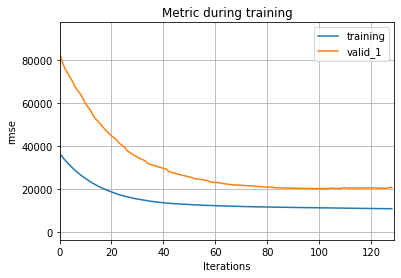

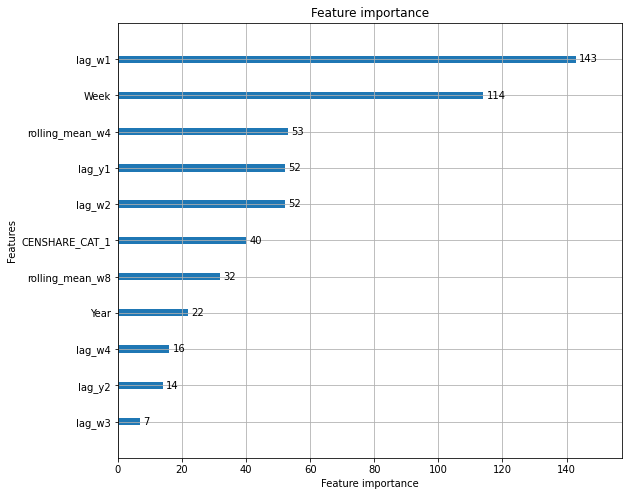

In [19]:
for week, year in splits:
    print(f'****** {year}W{week} ******')
    
    mod = lgb.Booster(model_file=path_models + f'gbm_{year}w{week}.txt')
    evals = pickle.load(open(path_models + f'evals_result_{year}w{week}.pkl', 'rb'))

    ax = lgb.plot_metric(evals)
    plt.show()
    
    ax = lgb.plot_importance(mod, figsize=(10,8))
    plt.gcf().subplots_adjust(left=0.2)
    plt.show()
    

In [20]:
# Gather results of this article category and store them in general result_df
results_df = x_test[['Week', 'Year', 'CENSHARE_CAT_1']].copy()
results_df = utils.decode_categorical(results_df, encoders_dict)
results_df[target_variable] = list(y_test)
results_df['Prediction'] = list(y_pred)
results_df

,Week,Year,CENSHARE_CAT_1,Turnover,Prediction
4993,47,2020,Bad,82275.671875,76385.101003
4994,47,2020,Beauty,89.500000,319.543670
4995,47,2020,Bett,109313.976562,113402.914530
4996,47,2020,Damen Accessoires,18353.869141,17452.571997
4997,47,2020,Elektronik Gadget,32579.109375,23505.424424
4998,47,2020,Gewurze,24.900000,319.543670
4999,47,2020,Heim & Haushalt,20785.519531,19850.236564
5000,47,2020,Herren,560.000000,405.377670
5001,47,2020,Kinder,632.859985,460.373312
5002,47,2020,Kuche,292367.937500,234724.481253


In [21]:
mean_squared_error(results_df.Turnover, results_df.Prediction, squared=False)

20173.311286614302

# Compute Bottom Level Forecasts

In [24]:
df['rolling_mean_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=4).mean())

df['rolling_mean_w8'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=8).mean())

df['lag_w1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1))

df['lag_w2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(2))

df['lag_w3'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(3))

df['lag_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(4))

df['lag_y1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(52))

df['lag_y2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(104))


In [25]:
cat_features = [
'Week', 'Year', 'Site_ID', 'SKU','Season_Year',
       'Vendor_ID', 'Price_Level', 'Web_Article', 'CENSHARE_CAT_1',
       'CENSHARE_CAT_2', 'CENSHARE_CAT_3'
]

num_features = [
'rolling_mean_w4', 'lag_w1',
       'lag_w2', 'lag_w3', 'lag_w4', 'lag_y1', 'lag_y2'
]

features = cat_features + num_features

In [26]:
# Convert categorical features to integers 
df, encoders_dict = utils.encode_categorical(df, cat_features, return_encoders = True)

In [27]:
splits = utils.get_splits(df, fh=forecast_horizon, n_splits=1)

In [28]:
model_params = {
    'seed': 10,
    'objective': 'poisson',
    'metric': 'rmse',
    'num_leaves': 2^4,
    'max_bin': 1000,
    }

In [29]:
rmse = []

for week, year in splits:
    print(f'\n\n****** {year}W{week} ******')
    
    evals_result = {}
    
    week=int(week)
    year=int(year)
    
    # Train data: same year and past week OR past year
    x_train = df.loc[((df.Year == (Week(year, week))[0]) & (df.Week <= (Week(year, week))[1])) | (df.Year < (Week(year, week))[0])][features]
    y_train = df.loc[((df.Year == (Week(year, week))[0]) & (df.Week <= (Week(year, week))[1])) | (df.Year < (Week(year, week))[0])][target_variable]

    x_test = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]][features]
    y_test = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]][target_variable]
    
    
    
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )
    
    
    
    gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                   )

    
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
    
    gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 
    
    evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
    pickle.dump(evals_result, evals_result_p)
    evals_result_p.close()
    
    rmse.append(mean_squared_error(y_test, y_pred, squared=False))




****** 5W45 ******


c:\dev\verteiler\venv5\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.266337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14617
[LightGBM] [Info] Number of data points in the train set: 7762170, number of used features: 18
[LightGBM] [Info] Start training from score 2.718292


c:\dev\verteiler\venv5\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv5\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 101.9	valid_1's rmse: 119.819
[50]	training's rmse: 107.706	valid_1's rmse: 115.631
[75]	training's rmse: 99.8425	valid_1's rmse: 112.838
[100]	training's rmse: 90.4634	valid_1's rmse: 108.069
[125]	training's rmse: 87.9034	valid_1's rmse: 106.364
[150]	training's rmse: 86.4214	valid_1's rmse: 105.831
[175]	training's rmse: 85.6505	valid_1's rmse: 105.107
[200]	training's rmse: 85.177	valid_1's rmse: 104.791
[225]	training's rmse: 84.4582	valid_1's rmse: 103.76
[250]	training's rmse: 83.813	valid_1's rmse: 102.926
[275]	training's rmse: 83.4463	valid_1's rmse: 102.739
[300]	training's rmse: 83.0224	valid_1's rmse: 102.895
Early stopping, best iteration is:
[284]	training's rmse: 83.295	valid_1's rmse: 102.695


****** 5W45 ******


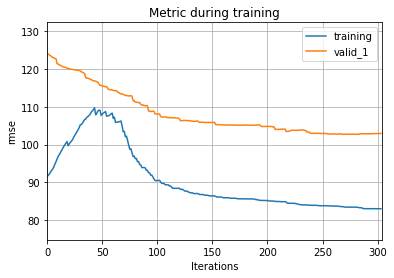

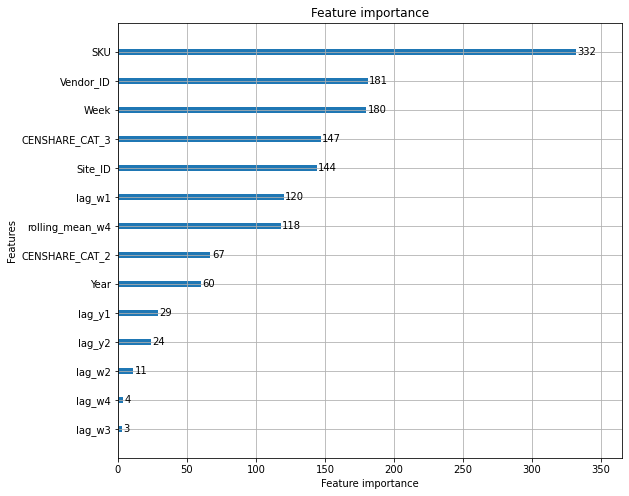

In [30]:
for week, year in splits:
    print(f'****** {year}W{week} ******')
    
    mod = lgb.Booster(model_file=path_models + f'gbm_{year}w{week}.txt')
    evals = pickle.load(open(path_models + f'evals_result_{year}w{week}.pkl', 'rb'))

    ax = lgb.plot_metric(evals)
    plt.show()
    
    ax = lgb.plot_importance(mod, figsize=(10,8))
    plt.gcf().subplots_adjust(left=0.2)
    plt.show()
    

In [31]:
results_bottom_level = x_test[['Week', 'Year', 'Site_ID','SKU','CENSHARE_CAT_1']].copy()
results_bottom_level = utils.decode_categorical(results_bottom_level, encoders_dict)
results_bottom_level[target_variable] = list(y_test)
results_bottom_level['Prediction'] = list(y_pred)
results_bottom_level

,Week,Year,Site_ID,SKU,CENSHARE_CAT_1,Turnover,Prediction
307,47,2020,101,1014557,Kuche,29.900000,30.433983
615,47,2020,102,1014557,Kuche,0.000000,10.423633
923,47,2020,103,1014557,Kuche,0.000000,11.388557
1231,47,2020,106,1014557,Kuche,0.000000,12.618583
1539,47,2020,107,1014557,Kuche,0.000000,15.539510
...,...,...,...,...,...,...,...
7821434,47,2020,101,1289328500,Ordnung & Aufbewahrung,56.090000,101.660023
7821435,47,2020,101,1289328600,Ordnung & Aufbewahrung,29.799999,101.660023
7821436,47,2020,101,1289328700,Ordnung & Aufbewahrung,32.869999,101.660023
7821437,47,2020,101,1289328800,Ordnung & Aufbewahrung,27.600000,101.660023


## Correct bottom level Forecasts based on aggregated ones

In [32]:
for cat in results_bottom_level.CENSHARE_CAT_1.drop_duplicates():
    factor = results_bottom_level.loc[results_bottom_level.CENSHARE_CAT_1 == cat].Prediction.sum()  / float(results_df.loc[results_df.CENSHARE_CAT_1 == cat].Prediction)
    results_bottom_level.loc[results_bottom_level.CENSHARE_CAT_1 == cat,'Prediction_v2'] = results_bottom_level.Prediction / factor


# Validate Forecasts

In [33]:
mean_squared_error(results_bottom_level.Prediction_v2, results_bottom_level.Turnover, squared=False)

103.39059746034596